In [1]:
import sympy as sp
from sympt import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import re 


import random
random.seed(42)  # Set a seed for reproducibility


from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor

import sys
import os
sys.path.append("/home/leander/GoogleDriveSync/PhD/Python/")
sys.path.append("/home/leander/GoogleDriveSync/PhD/Python/Researc_Projects/Spin Qubits and Skyrmions/")

from Elliptical_Well import EllipticalConfinement
from Packages.utils import apply_subs

from Cylindrical_Magnet import CylindricalMagnet

from matplotlib.lines import Line2D

# ---------------------------------------------------
# Matplotlib settings (publication-ready)
# ---------------------------------------------------
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # default text size
plt.rc('axes', titlesize=22)     # axes title
plt.rc('axes', labelsize=20)     # x and y labels
plt.rc('xtick', labelsize=14)    # tick labels
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', linewidth=2, markersize=6)
plt.rc('axes', linewidth=1)
plt.rc('xtick.major', size=6, width=1)
plt.rc('ytick.major', size=6, width=1)


In [2]:
import pandas as pd

path = 'skyrmion_data/'

def skyrmion_data(file_name):
    data = pd.read_csv(path + file_name)

    columns = data.columns

    B_skyrmion_x = data[columns[0]].to_numpy()
    B_skyrmion_y = data[columns[1]].to_numpy()
    B_skyrmion_z = data[columns[2]].to_numpy()

    X = data[columns[3]].to_numpy() * 1e9
    Y = data[columns[4]].to_numpy() * 1e9
    Z = data[columns[5]].to_numpy() * 1e9

    cut_points = np.max([np.sum(Y == Y[0]), np.sum(X == X[0])])

    X = X.reshape(cut_points, cut_points)
    X_pos = X[0, 0] + (X[0,-1] - X[0,0]) / 2
    X = X - X_pos
    Y = Y.reshape(cut_points, cut_points)
    Y_pos = Y[0, 0] + (Y[-1,0] - Y[0,0]) / 2
    Y = Y - Y_pos
    Z = Z.reshape(cut_points, cut_points)

    B_skyrmion_x = B_skyrmion_x.reshape(cut_points, cut_points)
    B_skyrmion_y = B_skyrmion_y.reshape(cut_points, cut_points)
    B_skyrmion_z = B_skyrmion_z.reshape(cut_points, cut_points)

    return B_skyrmion_x, B_skyrmion_y, B_skyrmion_z, X, Y, Z, data

def skyrmion_line_data(file_name):
    data = pd.read_csv(path + file_name)

    colums_to_drop = ["vtkValidPointMask","arc_length"]
    data = data.drop(columns=colums_to_drop)

    columns = data.columns

    B_skyrmion_x = data[columns[0]].to_numpy()
    B_skyrmion_y = data[columns[1]].to_numpy()
    B_skyrmion_z = data[columns[2]].to_numpy()

    X = data[columns[3]].to_numpy() * 1e9
    Y = data[columns[4]].to_numpy() * 1e9
    Z = data[columns[5]].to_numpy() * 1e9


    X = X - Y[0]
    Y = Y - Y[0]

    return B_skyrmion_x, B_skyrmion_y, B_skyrmion_z, X, Y, Z, data


In [3]:
# Defining Constants
hbar_value = 1.054571817e-34  # Planck constant over 2π, in J·s
e_constant = 1.602176634e-19  # Elementary charge magnitude, in C
e_charge = -e_constant        # Electron charge, in C
m_electron = 9.10938356e-31   # Mass of a free electron, in kg
m_si = 0.19 * m_electron  # Effective mass of electron in silicon conduction band
mu_0 = 4 * np.pi * 1e-7  # Vacuum permeability, in T·m/A

# Hamiltonian Setup

Here we are defining the variables for the Hamiltonian as unitless quantities. All the frequencies are defined in terms of the confinement frequency $\omega_x$ such that

$$
\Omega = k_\Omega \omega_x
$$

In [4]:
H_conf = EllipticalConfinement()
H_conf.H

hbar*omega_x*(k_+*(1/2 + Dagger(a_+)*a_+) + k_-*(1/2 + Dagger(a_-)*a_-))

In [6]:
Spin = RDBasis('sigma', dim=2)
s0, sx, sy, sz = Spin.basis
spin_vector = sp.Matrix([sx, sy, sz])


kB = RDSymbol('k_B', real=True, positive=True)                  # External magnetic field
B_tilde = sp.Matrix([0, 0, kB])                                 # External magnetic field in the z-direction

# Unitless unperturbed Hamiltonian (Equation 8)

H0 = H_conf.H / (hbar * H_conf.omega_x) - sp.Rational(1, 2) * B_tilde.dot(spin_vector)
H0

-k_B*sigma_3/2 + k_+*(1/2 + Dagger(a_+)*a_+) + k_-*(1/2 + Dagger(a_-)*a_-)

In [7]:
expansion_order = 5

# Dummy Taylor expansion
B_sk_x = compute_b(expansion_order, 'x', H_conf.x, H_conf.y)
B_sk_y = compute_b(expansion_order, 'y', H_conf.x, H_conf.y)
B_sk_z = compute_b(expansion_order, 'z', H_conf.x, H_conf.y)


kBsk = RDSymbol('k_{B_\\text{sk}}', real=True, positive=True)       # Magnetic field of the Skyrmion

B_sk = -kBsk * sp.Matrix([B_sk_x, B_sk_y, B_sk_z])                  # kBsk is the strength of the Skyrmion magnetic field and points on the opposite direction of the external magnetic field
b_sk_symbols = list(B_sk_x.atoms(RDSymbol)) + list(B_sk_y.atoms(RDSymbol)) + list(B_sk_z.atoms(RDSymbol))

# Unitless Skyrmion Zeeman Hamiltonian (Equation 9)
V = -sp.Rational(1, 2) * B_sk.dot(spin_vector)
V = V.expand()
V

NameError: name 'compute_b' is not defined

In [7]:
# Dummy substitution dictionaries for Pauli matrices
sigma_x, sigma_y, sigma_z = sp.symbols('sigma_x sigma_y sigma_z', commutative=False)
subs_paulis_to_symbols = {
    sx : sigma_x,
    sy : sigma_y,
    sz : sigma_z,
}

inv_subs_paulis_to_symbols = {
    sigma_x : sx,
    sigma_y : sy,
    sigma_z : sz,
}

# Separate terms by their position operator powers x^n y^m
V_terms = [k * v.subs(inv_subs_paulis_to_symbols) for k,v in group_by_operators(apply_subs(V, subs_paulis_to_symbols)).items()]
V_terms = [apply_subs(v_term.subs(H_conf.pos_to_new_basis_circular_confinement), H_conf.normal_ordering) for v_term in tqdm(V_terms)]

100%|██████████| 21/21 [03:20<00:00,  9.55s/it]


In [8]:
# Driving Hamiltonian
kE = sp.symbols('k_E', real=True) # lE = kE lx

# Unitless Drive H = 1/hbar omegax * (-e E(t) x)
H_Drive = (-1 / ( 2* kE**3 * H_conf.lx) * (H_conf.x)).subs(H_conf.pos_to_new_basis_circular_confinement)
H_Drive

-x_0*(Dagger(a_+) + a_+ + I*Dagger(a_-) - I*a_-)/(2*k_E**3)

# Obtaining Effective Hamiltonian

In [9]:
def compute_effective_frame(args):
    """
    Compute the effective frame for a given set of arguments.
    """
    i, V_ = args
    Eff_frame = EffectiveFrame(H0 + V_, subspaces=[Spin], verbose=False)
    Eff_frame.solve(method='FD')
    Eff_frame.get_H(return_form='matrix')
    H_eff_2 = Eff_frame.H_corrections.get(2, 0)
    H_eff_1 = Eff_frame.H_corrections.get(1, 0)
    H_eff_Drive = Eff_frame.rotate(H_Drive, max_order=1, return_form='matrix')

    H_cross_terms = {}
    for j, term in enumerate(V_terms):
        if i == j:
            continue
        H_cross_terms[j] = Eff_frame.rotate_corrections(term, max_order=2, return_form='matrix')

    return i, H_eff_1, H_eff_2, H_eff_Drive, H_cross_terms

In [10]:
inputs = [(i, H1) for i, H1 in enumerate(V_terms)]

random.shuffle(inputs)  # Shuffle the inputs to ensure random order of execution

# Use a multiprocessing Pool
with ProcessPoolExecutor(cpu_count()) as executor:
    results = list(tqdm(executor.map(compute_effective_frame, inputs), total=len(inputs)))

# Collect results
H_eff_1 = {}
H_eff_2 = {}
H_eff_Drive = {}
H_eff_cross = {}

for i, h1, h2, hd, h_cross in tqdm(results):
    H_eff_1[i] = h1
    H_eff_2[i] = h2
    H_eff_Drive[i] = hd
    H_eff_cross[i] = h_cross

100%|██████████| 21/21 [00:00<00:00, 302681.73it/s]


## Defining Qubit Frequency Corrections

In [11]:
project_into_qubit = {
    H_conf.a_m : 0,
    H_conf.ad_m : 0,
    H_conf.a_p : 0,
    H_conf.ad_p : 0,
}


H_qubit_1 = [h1.subs(project_into_qubit) for h1 in H_eff_1.values() if h1 != 0]
H_qubit_2 = [h2.subs(project_into_qubit) for h2 in H_eff_2.values() if h2 != 0]
H_qubit_Drive = [hd.subs(project_into_qubit) for hd in H_eff_Drive.values() if hd != 0]

In [12]:
def project_cross_term(h):
    return sp.Rational(1, 2) * h[2].subs(project_into_qubit)

H_qubit_cross = []

for h_qubit_cross_ in H_eff_cross.values():
    with ProcessPoolExecutor(cpu_count()) as executor:
        results = list(executor.map(project_cross_term, h_qubit_cross_.values()))
    H_qubit_cross += results

In [13]:
H1 = sp.Add(*H_qubit_1).expand()
delta_1 = sp.simplify(H1[0, 0] - H1[1, 1])
delta_1

k_{B_\text{sk}}*(b_z^{(0)} + 2*b_z^{(x^2)}*l_x**2*x_0**2 + 4*b_z^{(x^2y^2)}*l_x**4*x_0**4 + 12*b_z^{(x^4)}*l_x**4*x_0**4 + 2*b_z^{(y^2)}*l_x**2*x_0**2 + 12*b_z^{(y^4)}*l_x**4*x_0**4)

In [14]:
delta_1.collect([2 * H_conf.x0**2* H_conf.lx**2])

k_{B_\text{sk}}*(b_z^{(0)} + 4*l_x**4*x_0**4*(b_z^{(x^2y^2)} + 3*b_z^{(x^4)} + 3*b_z^{(y^4)}) + 2*l_x**2*x_0**2*(b_z^{(x^2)} + b_z^{(y^2)}))

In [15]:
H2 = sp.Add(*H_qubit_2).expand() + sp.Add(*H_qubit_cross).expand()
delta_2 = (H2[0, 0] - H2[1, 1])

In [16]:
delta_1_f = sp.lambdify((kB, kBsk, H_conf.lx, H_conf.x0, *b_sk_symbols), delta_1, modules='numpy')

In [17]:
delta_2_f = sp.lambdify((kB, kBsk, H_conf.lx, H_conf.x0, *b_sk_symbols), delta_2.subs(H_conf.subs_kp_km_circular), modules='numpy')

In [18]:
l0 = 60 # Confinement length in nm
omega_0 = hbar_value / (m_si * (l0 * 1e-9)**2) # Confinement frequency

B_ext = 38e-3 + 16e-3 # Magnetic field in T
B_tilde = e_constant * B_ext / m_electron

omega_c = e_constant * B_ext / m_si
Omega_0 = np.sqrt(omega_0**2 + (omega_c**2) / 4)

x0 = np.sqrt(omega_0 / (4 * Omega_0))

M = 1e6 # Magnetization in A/m
B_sk_val = mu_0 * M / (4 * np.pi) # Magnetic field of the skyrmion in T
B_sk_tilde = e_constant * B_sk_val / m_electron

In [19]:
D_symbol = sp.Symbol('D', positive=True, real=True)
Dz_symbol, L_symbol = sp.symbols('D_z L', positive=True, real=True)

xi_plus, xi_minus = sp.symbols('xi_+ xi_-', positive=True, real=True)

f = lambda xi: sp.sqrt(D_symbol**2 + xi**2)

delta_1_theory = 0
cs = [1, -2, 2]

for n in range(3):
    delta_1_theory += 2 * sp.pi * cs[n] * (sp.sqrt(2) * H_conf.x0 * H_conf.lx)**(2*n) * (f(xi_plus).diff(xi_plus, 2*n + 1).factor() - f(xi_minus).diff(xi_minus, 2*n + 1).factor()).subs(xi_plus, 2*Dz_symbol + L_symbol).subs(xi_minus, 2*Dz_symbol - L_symbol)

delta_1_theory_f = sp.lambdify((D_symbol, Dz_symbol, L_symbol, H_conf.lx, H_conf.x0), delta_1_theory, modules='numpy')

In [20]:
files = os.listdir(path)
magnetization_files = [file for file in files if file.startswith("magnetization") and file.endswith("_lineplot.csv")]
B_demag_files = [file for file in files if file.startswith("B_demag_-100nm") and not file.endswith("_lineplot.csv")]

K_values_mag = [float(re.search(r'K([-+]\d+\.\d+)', file).group(1)) for file in magnetization_files]
K_values = [float(re.search(r'K([-+]\d+\.\d+)', file).group(1)) for file in B_demag_files]

Ks_to_show = [-0.01, -0.005, 0.0, 0.0016]

i_k_0 = np.argmin(np.abs(np.array(K_values) - 0.01))
line_file = B_demag_files[i_k_0]
# remove .csv and add _lineplot.csv
line_file = line_file.replace(".csv", "_lineplot.csv")
print("Using line file:", line_file)
B_skyrmion_x, B_skyrmion_y, B_skyrmion_z, X, Y, Z, data = skyrmion_line_data(line_file)
B_z_base = 16e-3 #B_skyrmion_z[0]
print("Base field at center:", B_z_base)

skyrmions = {}

for i, K in enumerate(Ks_to_show):
    mag_file = magnetization_files[K_values_mag.index(K)]
    Bdemag_file = B_demag_files[K_values.index(K)]

    M_skyrmion_x, M_skyrmion_y, M_skyrmion_z, X, Y, Z, data = skyrmion_line_data(mag_file)
    B_demag_x, B_demag_y, B_demag_z, X_b, Y_b, Z_b, data_b = skyrmion_data(Bdemag_file)

    B_demag_z = B_demag_z - B_z_base

    Mz_sign_changes = np.where(np.diff(np.sign(M_skyrmion_z)))[0]
    diameter = np.diff(X[Mz_sign_changes])[0]
    print(f"K = {K}: Diameter = {diameter} nm")
    skyrmion_taylor_series = numerical_taylor_series([B_demag_x, B_demag_y, B_demag_z], 3, np.abs(X_b[0, 0] - X_b[0, 1]), method='ndtools', X=X_b, Y=Y_b)

    skyrmions[K] = {
        'D': np.abs(diameter),
        'bsk_values' : skyrmion_taylor_series,
    }

Using line file: B_demag_-100nm_0.038T_K+0.01_lineplot.csv
Base field at center: 0.016
K = -0.01: Diameter = 101.152 nm
K = -0.005: Diameter = 96.63200000000002 nm
K = 0.0: Diameter = 89.25400000000002 nm
K = 0.0016: Diameter = 83.06400000000002 nm


In [38]:
import importlib
import paper_utils

importlib.reload(paper_utils)

from paper_utils import compute_b, compute_bk_values, numerical_taylor_series


Typical variation due to g-factor variability: 0.027845161410798656 GHz


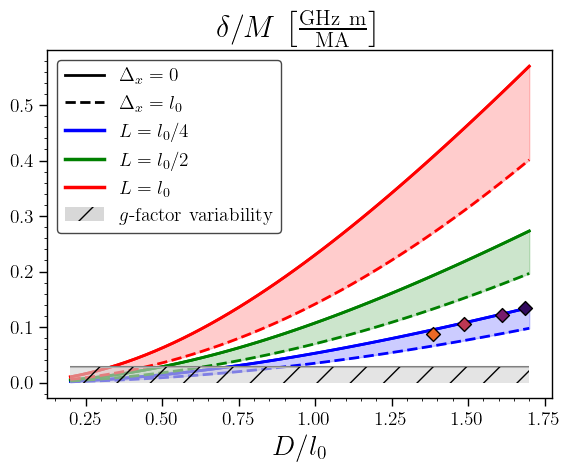

In [39]:
# ---------------------------------------------------
# Parameters
# ---------------------------------------------------
l0_symbol = sp.Symbol('l_0', real=True, positive=True)
L_ = np.array([1/4, 1/2, 1]) * l0
D = np.linspace(0.2, 1.7) * l0   # Diameter of the skyrmion in nm

Dx_ = np.array([0, 1]) * l0
Dy = 0
Dz = 150   # nm

# ---------------------------------------------------
# Plot
# ---------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

base_palette = ["blue", "green", "red"]#sns.color_palette("bright", len(L_))
line_style = ['-', '--']
markers = [None, None, None, None]

# Store results for later filling
curves = {}

for j, Dx in enumerate(Dx_):
    for i, L in enumerate(L_):
        b_sk_values = compute_bk_values(D, L, Dx, Dy, Dz, 1)
        b_sk_values = [b_sk_values[key] for key in b_sk_symbols]

        qubit_delta_1 = delta_1_f(B_tilde / omega_0, B_sk_tilde / omega_0,
                                  l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e9)
        
        if Dx == 0:
            theory_line = delta_1_theory_f(D, Dz, L, l0, x0) * B_sk_tilde / (2*np.pi*1e9)
            ax.plot(D/l0, theory_line,
                    color=base_palette[i], lw=2, ls=line_style[j], 
                    marker=markers[j], markersize=6, markevery=10, markerfacecolor='white')

        ax.plot(D/l0, qubit_delta_1,
                color=base_palette[i], lw=2, ls=line_style[j], 
                marker=markers[j], markersize=6, markevery=10, markerfacecolor='white')



        # Save curve for fill_between
        curves[(i, j)] = qubit_delta_1

# ---------------------------------------------------
# Example fill between solid ('-') and dash-dot ('-.')
# ---------------------------------------------------
for i, L in enumerate(L_):
    y1 = curves[(i, 0)]  # solid line (j=0 → '-')
    y2 = curves[(i, 1)]  # dash-dot line (j=1 → '-.')
    ax.fill_between(D/l0, y1, y2, color=base_palette[i], alpha=0.2)


# ---------------------------------------------------
# Add points for numerical skyrmion data
# ---------------------------------------------------

colors = sns.color_palette("inferno", len(Ks_to_show) + 1)
for idx, K in enumerate(Ks_to_show):
    D_sk = skyrmions[K]['D']
    b_sk_values = skyrmions[K]['bsk_values']
    b_sk_values = [b_sk_values.get(key, 0) for key in b_sk_symbols]

    qubit_delta_1 = delta_1_f(B_tilde / omega_0, 1,
                              l0, x0, *b_sk_values) * e_charge / m_electron * 1/(2*np.pi*1e9)
    qubit_delta_2 = delta_2_f(B_tilde / omega_0, 1,
                              l0, x0, *b_sk_values) * e_charge / m_electron * 1/(2*np.pi*1e9)

    ax.scatter(D_sk/l0, np.abs(qubit_delta_1), color=colors[idx], s=50, edgecolor="black", zorder=10, marker='D')

# ---------------------------------------------------
# Add a gray region showing the typical variation due to g-factor and confinement variability
# ---------------------------------------------------

g_factor_variation = 0.05  # ±5% variation in g-factor

Delta_qubit = np.abs(e_charge * (2 - 1.993) / (2 * m_si) * B_ext / (2 * np.pi * 1e9))
print("Typical variation due to g-factor variability:", Delta_qubit, "GHz")

# Rectangle with hatch to indicate variability
patch_rectangle = Rectangle((D[0]/l0, 0), D[-1]/l0 - D[0]/l0, Delta_qubit, fc='lightgray', hatch='/', zorder=10, alpha=0.6)
ax.hlines(Delta_qubit, D[0]/l0, D[-1]/l0, colors='gray', lw=1.5)
ax.add_patch(patch_rectangle)

# ---------------------------------------------------
# Axis labels
# ---------------------------------------------------
ax.set_xlabel(r"$D / l_0$")
#ax.set_ylabel(r"$\left[\frac{\mathrm{GHz}~\mathrm{m}}{\mathrm{MA}}\right]$")
ax.set_title(r"$\delta/M$ $\left[\frac{\mathrm{GHz}~\mathrm{m}}{\mathrm{MA}}\right]$", pad=10)

# ---------------------------------------------------
# Legend (styles + colors)
# ---------------------------------------------------
style_handles = [
    Line2D([0], [0], color="black", lw=2, label=r"$\Delta_x = " + f"{sp.nsimplify(Dx/l0) * l0_symbol}$", ls=line_style[j], marker=markers[j], markerfacecolor='white')
    for j, Dx in enumerate(Dx_)
]
color_handles = [
    Line2D([0], [0], color=base_palette[i], lw=2.5,
           label=fr"$L = {sp.nsimplify(L/l0) * l0_symbol}$")
    for i, L in enumerate(L_)
]


# Use the gray patch to represent the g-factor variability
g_factor_handle = Rectangle((0, 0), 1, 1, fc='gray', alpha=0.3, hatch='/',
                            label=r"$g$-factor variability")



ax.legend(handles=style_handles + color_handles + [g_factor_handle],
          frameon=True, framealpha=0.9, edgecolor="0.2")

# ---------------------------------------------------
# Minor ticks and layout
# ---------------------------------------------------
y_min, y_max = ax.get_ylim()
#ax.set_ylim(0, y_max)
ax.minorticks_on()
fig.tight_layout()

plt.show()
fig.savefig("figures/qubit_splitting_vs_D_skyrmion.pdf", dpi=300)

0.4084084084084084
0.5224224224224224
0.342042042042042
0.47477477477477475


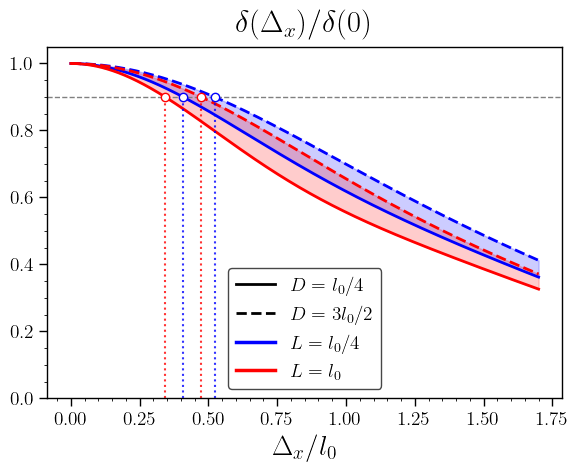

In [40]:
# ---------------------------------------------------
# Parameters
# ---------------------------------------------------
l0_symbol = sp.Symbol('l_0', real=True, positive=True)
L_ = np.array([1/4,  1]) * l0
D_ = np.array([1/4, 3/2]) * l0   # Diameter of the skyrmion in nm

Dx = np.linspace(0, 1.7, 1000) * l0
Dy = 0
Dz = 150   # nm

# ---------------------------------------------------
# Plot
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

base_palette = ["blue", "red"]
line_style = ['-', '--', ':']  # for D values
markers = [None, None]    # can add if desired

curves = {}

for i, L in enumerate(L_):
    for j, D in enumerate(D_):
        theory_line = delta_1_theory_f(D, Dz, L, l0, x0) * B_sk_tilde / (2*np.pi*1e6)

        b_sk_values = compute_bk_values(D, L, Dx, Dy, Dz, 1)
        b_sk_values = [b_sk_values[key] for key in b_sk_symbols]

        qubit_delta_1 = delta_1_f(B_tilde / omega_0, B_sk_tilde / omega_0,
                                  l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6)
        qubit_delta_2 = delta_2_f(B_tilde / omega_0, B_sk_tilde / omega_0,
                                   l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6)

        deviation = (qubit_delta_1 + qubit_delta_2) / theory_line

        ax.plot(Dx/l0, deviation,
                color=base_palette[i], lw=2,
                ls=line_style[j])

        # save for fill_between
        curves[(i, j)] = deviation

# ---------------------------------------------------
# Fill between curves (for each L, between D=1/4 and D=1)
# ---------------------------------------------------
for i, L in enumerate(L_):
    y1 = curves[(i, 0)]
    y2 = curves[(i, len(D_)-1)]
    ax.fill_between(Dx/l0, y1, y2, color=base_palette[i], alpha=0.2)


# ---------------------------------------------------
# Axis labels
# ---------------------------------------------------
ax.set_xlabel(r"$\Delta_x / l_0$")
ax.set_title(r"$\delta(\Delta_x)/{\delta(0)}$", pad=10)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

#ax.set_yscale('log')

# ---------------------------------------------------
# Legend (styles = D, colors = L)
# ---------------------------------------------------

# separate into num and denom
num_dem_label = lambda x : '/'.join(filter(lambda x: x!='1',map(sp.latex, (sp.nsimplify(x/l0) * l0_symbol).as_numer_denom()))) if x != 0 else '0'

style_handles = [
    Line2D([0], [0], color="black", lw=2,
           label=fr"$D = {num_dem_label(D)}$",
           ls=line_style[j])
    for j, D in enumerate(D_)
]
color_handles = [
    Line2D([0], [0], color=base_palette[i], lw=2.5,
           label=fr"$L = {num_dem_label(L)}$")
    for i, L in enumerate(L_)
]

ax.legend(handles=style_handles + color_handles,
          frameon=True, framealpha=0.9, edgecolor="0.2",
          loc='lower center')

# ---------------------------------------------------
# Marker at Dx where deviation ≈ 0.1
# ---------------------------------------------------
target = 0.9
ax.axhline(target, color='gray', lw=1, ls='--')
for key, y in curves.items():
    idx = np.argmin(np.abs(y - target))
    x_at_target = Dx[idx] / l0
    y_at_target = y[idx]

    print(x_at_target)

    # place a marker at the intersection
    ax.plot(x_at_target, y_at_target,
            marker="o", markersize=6,
            color=base_palette[key[0]],
            markerfacecolor="white",  # to make visible
            zorder=5)
    
    # vertical line up to the marker
    ax.vlines(x_at_target, 0, y_at_target, color=base_palette[key[0]], ls=":", lw=1.5, alpha=0.8)

y_min, y_max = ax.get_ylim()
ax.set_ylim(0, y_max)

# ---------------------------------------------------
# Layout
# ---------------------------------------------------
ax.minorticks_on()
fig.tight_layout()
plt.show()

fig.savefig("figures/qubit_splitting_deviation_vs_Dx.pdf", dpi=300)

# Rabi Frequency

In [26]:
HD = sp.Add(*H_qubit_Drive)
HD_operators = group_by_operators(Spin.project(HD))

Ez = HD_operators.get(sz, 0)
Ex = HD_operators.get(sx, 0)
Ey = HD_operators.get(sy, 0)

In [27]:
sp.factor_terms(sp.factor_terms(sp.Add(*[term.simplify() for term in sp.series(Ex, kB, 0, 2).removeO().expand().collect(b_sk_symbols).subs(H_conf.subs_kp_km_circular).as_ordered_terms()])).subs(sp.sqrt(1 - 16*H_conf.x0**4), 2 * H_conf.kc * H_conf.x0**2).collect(2*kB*H_conf.kc).collect([2*H_conf.lx*H_conf.x0]))

k_{B_\text{sk}}*l_x*(b_x^{(x^1)}/4 + b_x^{(x^1y^2)}*l_x**2*x_0**2/2 + 3*b_x^{(x^1y^4)}*l_x**4*x_0**4 + 3*b_x^{(x^3)}*l_x**2*x_0**2/2 + 3*b_x^{(x^3y^2)}*l_x**4*x_0**4 + 15*b_x^{(x^5)}*l_x**4*x_0**4 - b_y^{(x^2y^1)}*k_B*k_c*l_x**2*x_0**2/2 - 3*b_y^{(x^2y^3)}*k_B*k_c*l_x**4*x_0**4 - 3*b_y^{(x^4y^1)}*k_B*k_c*l_x**4*x_0**4 - b_y^{(y^1)}*k_B*k_c/4 - 3*b_y^{(y^3)}*k_B*k_c*l_x**2*x_0**2/2 - 15*b_y^{(y^5)}*k_B*k_c*l_x**4*x_0**4)/k_E**3

In [28]:
sp.factor_terms(sp.factor_terms(sp.Add(*[term.simplify() for term in sp.series(Ey, kB, 0, 2).removeO().expand().collect(b_sk_symbols).subs(H_conf.subs_kp_km_circular).as_ordered_terms()])).subs(sp.sqrt(1 - 16*H_conf.x0**4), 2 * H_conf.kc * H_conf.x0**2).collect(2*kB*H_conf.kc).collect([2*H_conf.lx*H_conf.x0]))

k_{B_\text{sk}}*l_x*(b_x^{(x^2y^1)}*k_B*k_c*l_x**2*x_0**2/2 + 3*b_x^{(x^2y^3)}*k_B*k_c*l_x**4*x_0**4 + 3*b_x^{(x^4y^1)}*k_B*k_c*l_x**4*x_0**4 + b_x^{(y^1)}*k_B*k_c/4 + 3*b_x^{(y^3)}*k_B*k_c*l_x**2*x_0**2/2 + 15*b_x^{(y^5)}*k_B*k_c*l_x**4*x_0**4 + b_y^{(x^1)}/4 + b_y^{(x^1y^2)}*l_x**2*x_0**2/2 + 3*b_y^{(x^1y^4)}*l_x**4*x_0**4 + 3*b_y^{(x^3)}*l_x**2*x_0**2/2 + 3*b_y^{(x^3y^2)}*l_x**4*x_0**4 + 15*b_y^{(x^5)}*l_x**4*x_0**4)/k_E**3

In [29]:
sp.factor_terms(sp.factor_terms(sp.Add(*[term.simplify() for term in sp.series(Ez, kB, 0, 2).removeO().expand().collect(b_sk_symbols).subs(H_conf.subs_kp_km_circular).as_ordered_terms()])).subs(sp.sqrt(1 - 16*H_conf.x0**4), 2 * H_conf.kc * H_conf.x0**2).collect(2*kB*H_conf.kc).collect([2*H_conf.lx*H_conf.x0]))

k_{B_\text{sk}}*l_x*(b_z^{(x^1)}/4 + b_z^{(x^1y^2)}*l_x**2*x_0**2/2 + 3*b_z^{(x^1y^4)}*l_x**4*x_0**4 + 3*b_z^{(x^3)}*l_x**2*x_0**2/2 + 3*b_z^{(x^3y^2)}*l_x**4*x_0**4 + 15*b_z^{(x^5)}*l_x**4*x_0**4)/k_E**3

In [70]:
1.93e-7 * 3 * (np.sqrt(2) * x0 * l0)**2  * B_sk_tilde * l0 / (2*np.pi*1e6) / 4

np.float64(43.29117499897152)

In [68]:
-0.0020261450461183574 * B_sk_tilde * l0 / (2*np.pi*1e6) / 4

-85.0752683465298

In [73]:
-1.1513107528357124e-11 * 15 * (np.sqrt(2) * x0 * l0)**4 * B_sk_tilde * l0 / (2*np.pi*1e6) / 4 * 3

np.float64(-68.97852423442362)

In [53]:
{k:v for k,v in compute_bk_values(D=3/2 * l0, L=l0, Dx=0, Dy=0, Dz=150, B0 = 1).items()}

{b_x^{(0)}: 0.0,
 b_x^{(y^1)}: 0.0,
 b_x^{(x^1)}: -0.0020261450461183574,
 b_x^{(y^2)}: -0.0,
 b_x^{(x^1y^1)}: -0.0,
 b_x^{(x^2)}: -0.0,
 b_x^{(y^3)}: -0.0,
 b_x^{(x^1y^2)}: 1.9325428809720045e-07,
 b_x^{(x^2y^1)}: -0.0,
 b_x^{(x^3)}: 1.9325428809720045e-07,
 b_x^{(y^4)}: 0.0,
 b_x^{(x^1y^3)}: 0.0,
 b_x^{(x^2y^2)}: 0.0,
 b_x^{(x^3y^1)}: 0.0,
 b_x^{(x^4)}: 0.0,
 b_x^{(y^5)}: 0.0,
 b_x^{(x^1y^4)}: -1.1513107528357123e-11,
 b_x^{(x^2y^3)}: 0.0,
 b_x^{(x^3y^2)}: -2.3026215056714246e-11,
 b_x^{(x^4y^1)}: 0.0,
 b_x^{(x^5)}: -1.1513107528357124e-11,
 b_y^{(0)}: 0.0,
 b_y^{(y^1)}: -0.0020261450461183574,
 b_y^{(x^1)}: 0.0,
 b_y^{(y^2)}: -0.0,
 b_y^{(x^1y^1)}: -0.0,
 b_y^{(x^2)}: -0.0,
 b_y^{(y^3)}: 1.9325428809720045e-07,
 b_y^{(x^1y^2)}: -0.0,
 b_y^{(x^2y^1)}: 1.9325428809720045e-07,
 b_y^{(x^3)}: -0.0,
 b_y^{(y^4)}: 0.0,
 b_y^{(x^1y^3)}: 0.0,
 b_y^{(x^2y^2)}: 0.0,
 b_y^{(x^3y^1)}: 0.0,
 b_y^{(x^4)}: 0.0,
 b_y^{(y^5)}: -1.1513107528357124e-11,
 b_y^{(x^1y^4)}: 0.0,
 b_y^{(x^2y^3)}: -2.3026215

In [30]:
Ex_f = sp.lambdify((kE, kB, kBsk, H_conf.lx, H_conf.x0, *b_sk_symbols), Ex.subs(H_conf.subs_kp_km_circular), modules='numpy')
Ey_f = sp.lambdify((kE, kB, kBsk, H_conf.lx, H_conf.x0, *b_sk_symbols), Ey.subs(H_conf.subs_kp_km_circular), modules='numpy')
Ez_f = sp.lambdify((kE, kB, kBsk, H_conf.lx, H_conf.x0, *b_sk_symbols), Ez.subs(H_conf.subs_kp_km_circular), modules='numpy')

In [31]:
B_cal = 2 * sp.pi * (f(xi_plus).diff(xi_plus, 2).factor() - f(xi_minus).diff(xi_minus, 2).factor() - (2 * H_conf.x0 * H_conf.lx)**2 * (f(xi_plus).diff(xi_plus, 4).factor() - f(xi_minus).diff(xi_minus, 4).factor()))
B_cal = B_cal.subs(xi_plus, 2*Dz_symbol + L_symbol).subs(xi_minus, 2*Dz_symbol - L_symbol)
Omega_rabi = 1/4 * 1/kE**3 * (1 - kB**2 / 0.19 ) * B_cal * H_conf.lx
Omega_rabi_f = sp.lambdify((kE, kB, H_conf.lx, H_conf.x0, D_symbol, L_symbol, Dz_symbol), Omega_rabi.subs(H_conf.subs_kp_km_circular), modules='numpy')
B_cal_f = sp.lambdify((H_conf.x0, H_conf.lx, D_symbol, L_symbol, Dz_symbol), B_cal, modules='numpy')

K = -0.01: Ex = -6.55 MHz, Ey = -0.11 MHz, ExEy = 6.55 MHz, Ex theory = 16.51 MHz
K = -0.005: Ex = -5.88 MHz, Ey = -0.06 MHz, ExEy = 5.88 MHz, Ex theory = 15.55 MHz
K = 0.0: Ex = -4.96 MHz, Ey = -0.02 MHz, ExEy = 4.96 MHz, Ex theory = 13.96 MHz
K = 0.0016: Ex = -3.90 MHz, Ey = -0.02 MHz, ExEy = 3.90 MHz, Ex theory = 12.61 MHz


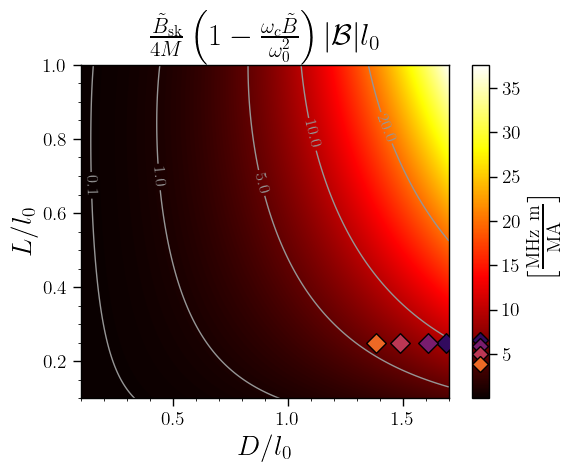

In [41]:
# ---------------------------------------------------
# Parameters
# ---------------------------------------------------
l0_symbol = sp.Symbol('l_0', real=True, positive=True)
L_ = np.linspace(0.1, 1, 1000) * l0
D_ = np.linspace(0.1, 1.7, 1000) * l0

D, L = np.meshgrid(D_, L_)

Dx = 0
Dy = 0
Dz = 150   # nm

B_val_vals = np.abs(B_cal_f(x0, l0, D, L, Dz)) * l0 * B_sk_tilde / 4 / (2 * np.pi * 1e6) * (1 - omega_c * B_tilde / omega_0**2)  # in MHz·m/MA

# ---------------------------------------------------
# Plot
# ---------------------------------------------------
# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))


im = ax.imshow(B_val_vals, extent=[D_.min()/l0, D_.max()/l0, L_.min()/l0, L_.max()/l0], 
               aspect='auto', origin='lower', cmap='hot')



# Add contour lines
contour_values = [0.1, 1, 5, 10, 20.0]  # whatever is relevant for B_val_vals
contours = ax.contour(D_/l0, L_/l0, B_val_vals, levels=contour_values, colors="#969696", linewidths=1)
ax.clabel(contours, inline=True, fontsize=12, fmt="%.1f")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\left[\frac{\mathrm{MHz}~\mathrm{m}}{\mathrm{MA}}\right]$")
cbar.ax.tick_params()


# -------------------------------------------
# Numerical points from skyrmion data
# -------------------------------------------
for idx, K in enumerate(Ks_to_show):
    D_sk = skyrmions[K]['D']
    b_sk_values = skyrmions[K]['bsk_values']
    b_sk_values = [b_sk_values.get(key, 0) for key in b_sk_symbols]

    Ex_val = np.abs(Ex_f(1, B_tilde / omega_0, 1, l0, x0, *b_sk_values)) * e_charge/m_electron * 1 / (2 * np.pi * 1e6)
    Ey_val = np.abs(Ey_f(1, B_tilde / omega_0, 1, l0, x0, *b_sk_values)) * e_charge/m_electron * 1 / (2 * np.pi * 1e6)
    #Ez_val = Ez_f(1, B_tilde / omega_0, 1, l0, x0, *b_sk_values)
    ExEy = np.sqrt(Ex_val**2 + Ey_val**2)
    
    b_sk_values = compute_bk_values(D_sk, 1/4 * l0, 0, 0, Dz, 1)
    b_sk_values = [b_sk_values[key] for key in b_sk_symbols]
    Ex_val_theory = np.abs(Ex_f(1, B_tilde / omega_0, B_sk_tilde / omega_0, l0, x0, *b_sk_values)) * omega_0 / (2 * np.pi * 1e6)
    print(f"K = {K}: Ex = {Ex_val:.2f} MHz, Ey = {Ey_val:.2f} MHz, ExEy = {ExEy:.2f} MHz, Ex theory = {Ex_val_theory:.2f} MHz")

    ax.scatter(D_sk/l0, 1/4, color=colors[idx], s=100, edgecolor="black", zorder=10, marker='D')
    cbar_y = (ExEy - B_val_vals.min()) / (B_val_vals.max() - B_val_vals.min()) * (cbar.ax.get_ylim()[1] - cbar.ax.get_ylim()[0]) + cbar.ax.get_ylim()[0]
    cbar.ax.plot([0.5], [cbar_y], marker="D", markersize=8, color="black", markerfacecolor=colors[idx], zorder=10)
    

# Title and labels
ax.set_title(r"$\frac{\tilde{B}_{\mathrm{sk}}}{4M} \left( 1 - \frac{\omega_c \tilde{B}}{\omega_0^2} \right) |\mathcal{B}| l_0$")
ax.set_xlabel(r"$D/l_0$")
ax.set_ylabel(r"$L/l_0$")

# Ticks and grid
ax.tick_params(axis='both', which='major')
ax.minorticks_on()
ax.grid(False)

plt.tight_layout()
plt.show()

fig.savefig("figures/rabi_frequency_strength_heatmap.pdf", dpi=300)

K = -0.01: Ex = -6.55 MHz, Ey = -0.11 MHz, ExEy = 6.55 MHz, Ex theory = 16.51 MHz
K = -0.005: Ex = -5.88 MHz, Ey = -0.06 MHz, ExEy = 5.88 MHz, Ex theory = 15.55 MHz
K = 0.0: Ex = -4.96 MHz, Ey = -0.02 MHz, ExEy = 4.96 MHz, Ex theory = 13.96 MHz
K = 0.0016: Ex = -3.90 MHz, Ey = -0.02 MHz, ExEy = 3.90 MHz, Ex theory = 12.61 MHz


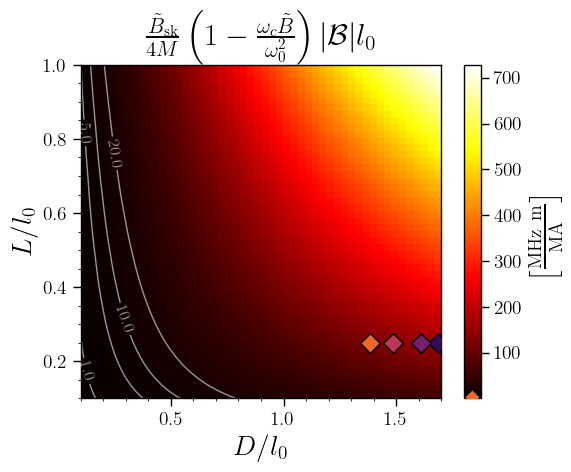

In [48]:
# ---------------------------------------------------
# Parameters
# ---------------------------------------------------
l0_symbol = sp.Symbol('l_0', real=True, positive=True)
L_ = np.linspace(0.1, 1, 50) * l0
D_ = np.linspace(0.1, 1.7, 50) * l0

D, L = np.meshgrid(D_, L_)

Dx = 0
Dy = 0
Dz = 150   # nm

bsk_values = compute_bk_values(D, L, 0, 0, Dz, 1)
b_sk_values = [bsk_values[key] for key in b_sk_symbols]

Ex_vals = np.abs(Ex_f(1, B_tilde / omega_0, 1, l0, x0, *b_sk_values) * e_charge/m_electron * 1 / (2 * np.pi * 1e6))
Ey_vals = np.abs(Ey_f(1, B_tilde / omega_0, 1, l0, x0, *b_sk_values) * e_charge/m_electron * 1 / (2 * np.pi * 1e6))
#Ez_vals = Ez_f(1

B_val_vals = np.sqrt(Ex_vals**2 + Ey_vals**2)  # in MHz

# ---------------------------------------------------
# Plot
# ---------------------------------------------------
# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))


im = ax.imshow(B_val_vals, extent=[D_.min()/l0, D_.max()/l0, L_.min()/l0, L_.max()/l0], 
               aspect='auto', origin='lower', cmap='hot')



# Add contour lines
contour_values = [0.1, 1, 5, 10, 20.0]  # whatever is relevant for B_val_vals
contours = ax.contour(D_/l0, L_/l0, B_val_vals, levels=contour_values, colors="#969696", linewidths=1)
ax.clabel(contours, inline=True, fontsize=12, fmt="%.1f")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\left[\frac{\mathrm{MHz}~\mathrm{m}}{\mathrm{MA}}\right]$")
cbar.ax.tick_params()


# -------------------------------------------
# Numerical points from skyrmion data
# -------------------------------------------
for idx, K in enumerate(Ks_to_show):
    D_sk = skyrmions[K]['D']
    b_sk_values = skyrmions[K]['bsk_values']
    b_sk_values = [b_sk_values.get(key, 0) for key in b_sk_symbols]

    Ex_val = np.abs(Ex_f(1, B_tilde / omega_0, 1, l0, x0, *b_sk_values)) * e_charge/m_electron * 1 / (2 * np.pi * 1e6)
    Ey_val = np.abs(Ey_f(1, B_tilde / omega_0, 1, l0, x0, *b_sk_values)) * e_charge/m_electron * 1 / (2 * np.pi * 1e6)
    #Ez_val = Ez_f(1, B_tilde / omega_0, 1, l0, x0, *b_sk_values)
    ExEy = np.sqrt(Ex_val**2 + Ey_val**2)
    
    b_sk_values = compute_bk_values(D_sk, 1/4 * l0, 0, 0, Dz, 1)
    b_sk_values = [b_sk_values[key] for key in b_sk_symbols]
    Ex_val_theory = np.abs(Ex_f(1, B_tilde / omega_0, B_sk_tilde / omega_0, l0, x0, *b_sk_values)) * omega_0 / (2 * np.pi * 1e6)
    print(f"K = {K}: Ex = {Ex_val:.2f} MHz, Ey = {Ey_val:.2f} MHz, ExEy = {ExEy:.2f} MHz, Ex theory = {Ex_val_theory:.2f} MHz")

    ax.scatter(D_sk/l0, 1/4, color=colors[idx], s=100, edgecolor="black", zorder=10, marker='D')
    cbar_y = (ExEy - B_val_vals.min()) / (B_val_vals.max() - B_val_vals.min()) * (cbar.ax.get_ylim()[1] - cbar.ax.get_ylim()[0]) + cbar.ax.get_ylim()[0]
    cbar.ax.plot([0.5], [cbar_y], marker="D", markersize=8, color="black", markerfacecolor=colors[idx], zorder=10)
    

# Title and labels
ax.set_title(r"$\frac{\tilde{B}_{\mathrm{sk}}}{4M} \left( 1 - \frac{\omega_c \tilde{B}}{\omega_0^2} \right) |\mathcal{B}| l_0$")
ax.set_xlabel(r"$D/l_0$")
ax.set_ylabel(r"$L/l_0$")

# Ticks and grid
ax.tick_params(axis='both', which='major')
ax.minorticks_on()
ax.grid(False)

plt.tight_layout()
plt.show()

fig.savefig("figures/rabi_frequency_strength_heatmap.pdf", dpi=300)

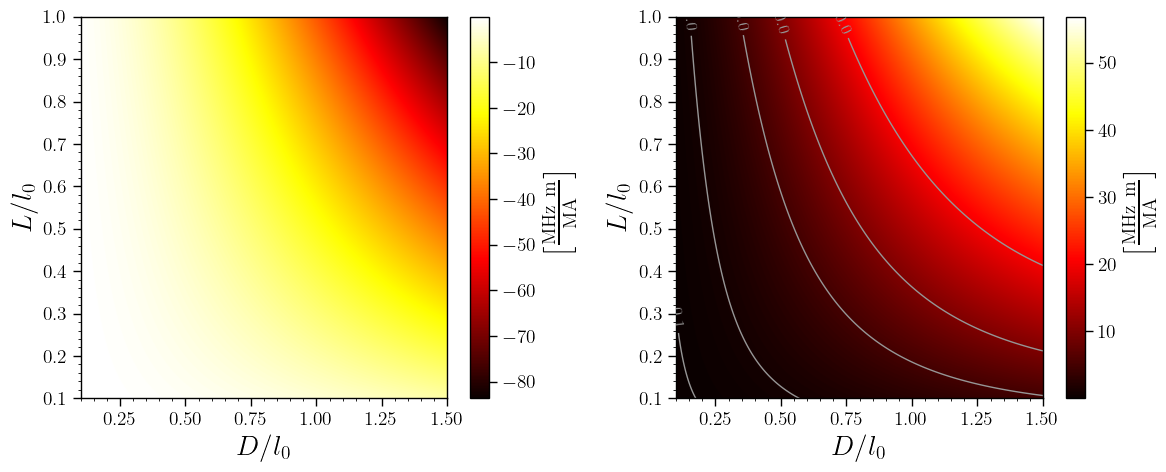

In [67]:
# ---------------------------------------------------
# Parameters
# ---------------------------------------------------
l0_symbol = sp.Symbol('l_0', real=True, positive=True)
L_ = np.linspace(0.1, 1, 1000) * l0
D_ = np.linspace(0.1, 3/2, 1000) * l0

D, L = np.meshgrid(D_, L_)

Dx = 0
Dy = 0
Dz = 150   # nm


B_cal_1 =  2 * sp.pi * (f(xi_plus).diff(xi_plus, 2).factor() - f(xi_minus).diff(xi_minus, 2).factor()).subs(xi_plus, 2*Dz_symbol + L_symbol).subs(xi_minus, 2*Dz_symbol - L_symbol)
B_cal_f1 = sp.lambdify((H_conf.x0, H_conf.lx, D_symbol, L_symbol, Dz_symbol), B_cal_1, modules='numpy')

B_cal_3 = -2 * sp.pi * (2 * H_conf.x0 * H_conf.lx)**2 * ((f(xi_plus).diff(xi_plus, 4).factor() - f(xi_minus).diff(xi_minus, 4).factor())).subs(xi_plus, 2*Dz_symbol + L_symbol).subs(xi_minus, 2*Dz_symbol - L_symbol)
B_cal_f3 = sp.lambdify((H_conf.x0, H_conf.lx, D_symbol, L_symbol, Dz_symbol), B_cal_3, modules='numpy')

B1_vals = B_cal_f1(x0, l0, D, L, Dz) * l0 * B_sk_tilde / 4 / (2 * np.pi * 1e6) * (1 - omega_c * B_tilde / omega_0**2)  # in MHz·m/MA
B3_vals = B_cal_f3(x0, l0, D, L, Dz) * l0 * B_sk_tilde / 4 / (2 * np.pi * 1e6) * (1 - omega_c * B_tilde / omega_0**2)  # in MHz·m/MA

# ---------------------------------------------------
# Plot
# ---------------------------------------------------
# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

B_val_vals = [B1_vals, B3_vals]

for i, ax in enumerate(axs):
    
    im = ax.imshow(B_val_vals[i], extent=[D_.min()/l0, D_.max()/l0, L_.min()/l0, L_.max()/l0], 
               aspect='auto', origin='lower', cmap='hot')

    # Add contour lines
    contour_values = [0.1, 1, 5, 10, 20.0]  # whatever is relevant for B_val_vals
    contours = ax.contour(D_/l0, L_/l0, B_val_vals[i], levels=contour_values, colors="#969696", linewidths=1)
    ax.clabel(contours, inline=True, fontsize=12, fmt="%.1f")

    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r"$\left[\frac{\mathrm{MHz}~\mathrm{m}}{\mathrm{MA}}\right]$")
    cbar.ax.tick_params()

# Title and labels
#ax.set_title(r"$\frac{\tilde{B}_{\mathrm{sk}}}{4M} \left( 1 - \frac{\omega_c \tilde{B}}{\omega_0^2} \right) |\mathcal{B}| l_0$")
    ax.set_xlabel(r"$D/l_0$")
    ax.set_ylabel(r"$L/l_0$")

# Ticks and grid
    ax.tick_params(axis='both', which='major')
    ax.minorticks_on()
    ax.grid(False)

plt.tight_layout()
plt.show()

#fig.savefig("figures/rabi_frequency_strength_heatmap.pdf", dpi=300)

[0.56597113 0.56178606 0.54941525 0.52939869 0.50259364 0.47011503
 0.43326002 0.39342385 0.35201436 0.31037201] 0.13444383226473425
[14.1249204  14.07753932 13.93609651 13.70269261 13.38082406 12.97536862
 12.49255085 11.93987647 11.32602421 10.66068687] 7.110365961573966
[2.94191109 2.91010845 2.81657305 2.66674925 2.46915581 2.23462633
 1.97538036 1.70403326 1.4326523  1.17195138] 0.2725054534121461
[63.21752997 62.98667024 62.29619371 61.15264783 59.56770173 57.55913876
 55.15197109 52.37943237 49.28358743 45.91532704] 26.825563839836718
0.2222222222222222
0.2222222222222222
0.2222222222222222
0.2222222222222222


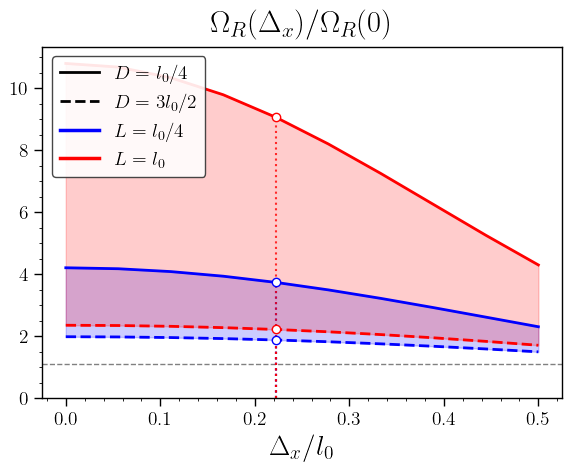

In [49]:
# ---------------------------------------------------
# Parameters
# ---------------------------------------------------
l0_symbol = sp.Symbol('l_0', real=True, positive=True)
L_ = np.array([1/4, 1]) * l0
D_ = np.array([1/4, 3/2]) * l0

Dx = np.linspace(0, 0.5, 10) * l0
Dy = 0
Dz = 150   # nm



# ---------------------------------------------------
# Plot
# ---------------------------------------------------
# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

base_palette = ["blue", "red"]
line_style = ['-', '--', ':']  # for D values
markers = [None, None]    # can add if desired

curves = {}

for i, L in enumerate(L_):
    for j, D in enumerate(D_):
        theory_line = np.abs(B_cal_f(x0, l0, D, L, Dz)) * l0 * B_sk_tilde / 4 / (2 * np.pi * 1e6) * (1 - omega_c * B_tilde / omega_0**2) 
        
        # (kE, kB, kBsk, H_conf.lx, H_conf.x0, *b_sk_symbols)

        b_sk_values = compute_bk_values(D, L, Dx, Dy, Dz, 1)
        b_sk_values = [b_sk_values[key] for key in b_sk_symbols]

        Ex_vals = np.abs(Ex_f(1, B_tilde / omega_0, B_sk_tilde / omega_0, l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6))
        Ey_vals = np.abs(Ey_f(1, B_tilde / omega_0, B_sk_tilde / omega_0, l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6))

        Omega_rabi = np.sqrt(Ex_vals**2 + Ey_vals**2)

        print(Omega_rabi, theory_line)

        deviation = np.abs(Omega_rabi / theory_line)

        ax.plot(Dx/l0, deviation,
                color=base_palette[i], lw=2,
                ls=line_style[j])

        # save for fill_between
        curves[(i, j)] = deviation
    
# ---------------------------------------------------
# Fill between curves (for each L, between D=1/4 and D=1)
# ---------------------------------------------------
for i, L in enumerate(L_):
    y1 = curves[(i, 0)]
    y2 = curves[(i, len(D_)-1)]
    ax.fill_between(Dx/l0, y1, y2, color=base_palette[i], alpha=0.2)

# ---------------------------------------------------
# Axis labels
# ---------------------------------------------------
ax.set_xlabel(r"$\Delta_x / l_0$")
ax.set_title(r"$\Omega_R(\Delta_x) /\Omega_R(0)$", pad=10)
#ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# ---------------------------------------------------
# Legend (styles = D, colors = L)
# ---------------------------------------------------
style_handles = [
    Line2D([0], [0], color="black", lw=2,
           label=fr"$D = {num_dem_label(D)}$",
           ls=line_style[j])
    for j, D in enumerate(D_)
]
color_handles = [
    Line2D([0], [0], color=base_palette[i], lw=2.5,
           label=fr"$L = {num_dem_label(L)}$")
    for i, L in enumerate(L_)
]

ax.legend(handles=style_handles + color_handles,
          frameon=True, framealpha=0.9, edgecolor="0.2",
          loc='upper left')

# ---------------------------------------------------
# Marker at Dx where deviation ≈ 0.1
# ---------------------------------------------------
target = 1.1
ax.axhline(target, color='gray', lw=1, ls='--')
for key, y in curves.items():
    idx = np.argmin(np.abs(y[:len(y)//2] - target))
    x_at_target = Dx[idx] / l0
    y_at_target = y[idx]

    print(x_at_target)

    # place a marker at the intersection
    ax.plot(x_at_target, y_at_target,
            marker="o", markersize=6,
            color=base_palette[key[0]],
            markerfacecolor="white",  # to make visible
            zorder=5)
    
    # vertical line up to the marker
    ax.vlines(x_at_target, 0, y_at_target, color=base_palette[key[0]], ls=":", lw=1.5, alpha=0.8)


#ax.set_yscale("log")
y_min, y_max = ax.get_ylim()
ax.set_ylim(0, y_max)
# ---------------------------------------------------
# Layout
# ---------------------------------------------------
ax.minorticks_on()
fig.tight_layout()
plt.show()


fig.savefig("figures/rabi_frequency_stability.pdf", dpi=300)

In [145]:

import numpy as np
from scipy.optimize import differential_evolution

# --- Example placeholder functions ---
def qubit_freq(D, L, Dx):
    Dz = 150  # nm
    b_sk_values = compute_bk_values(D, L, Dx, 0, Dz, 1)
    b_sk_values = [b_sk_values[key] for key in b_sk_symbols]

    qubit_delta_1 = delta_1_f(B_tilde / omega_0, B_sk_tilde / omega_0,
                              l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6)
    qubit_delta_2 = delta_2_f(B_tilde / omega_0, B_sk_tilde / omega_0,
                              l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6)
    return qubit_delta_1 + qubit_delta_2


def rabi_freq(D, L, Dx):
    Dz = 150  # nm
    b_sk_values = compute_bk_values(D, L, Dx, Dy, Dz, 1)
    b_sk_values = [b_sk_values[key] for key in b_sk_symbols]

    Ex_vals = np.abs(Ex_f(1, B_tilde / omega_0, B_sk_tilde / omega_0,
                          l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6))
    Ey_vals = np.abs(Ey_f(1, B_tilde / omega_0, B_sk_tilde / omega_0,
                          l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6))
    return np.sqrt(Ex_vals**2 + Ey_vals**2)


# --- Stability test ---
def stable_enough(D, L, dx_max=0.1*l0, n_points=5):
    """Check if qubit and Rabi frequencies stay within 10% for |Dx| ≤ dx_max"""
    fq0 = qubit_freq(D, L, 0)
    fr0 = rabi_freq(D, L, 0)

    Dx_vals = np.linspace(-dx_max, dx_max, n_points)
    for Dx in Dx_vals:
        fq = qubit_freq(D, L, Dx)
        fr = rabi_freq(D, L, Dx)

        if abs(fq - fq0) / (abs(fq0) + 1e-12) > 0.1:  # >10% change
            return False
        if abs(fr - fr0) / (abs(fr0) + 1e-12) > 0.1:  # >10% change
            return False
    return True


# --- Objective function ---
def objective(params):
    D, L = params
    if D <= 0 or L <= 0:
        return 1e6

    fq0 = qubit_freq(D, L, 0)
    fr0 = rabi_freq(D, L, 0)

    if not stable_enough(D, L):
        return 1e6  # reject unstable solutions

    # maximize fq * fr → minimize negative
    score = fq0 * fr0
    return -score


# --- Run optimization ---
bounds = [(0.2 * l0, 1.5 * l0),  # D range
          (0.2 * l0, l0)]  # L range

result = differential_evolution(objective, bounds, seed=1)

D_opt, L_opt = result.x
best_score = -result.fun

print(f"Optimal D = {D_opt:.3f}, L = {L_opt:.3f}")
print(f"Best score = {best_score:.4f}")
print(f"Qubit freq = {qubit_freq(D_opt, L_opt, 0):.3f}")
print(f"Rabi freq = {rabi_freq(D_opt, L_opt, 0):.3f}")


Optimal D = 90.000, L = 60.000
Best score = 12507.6738
Qubit freq = 464.688
Rabi freq = 26.916


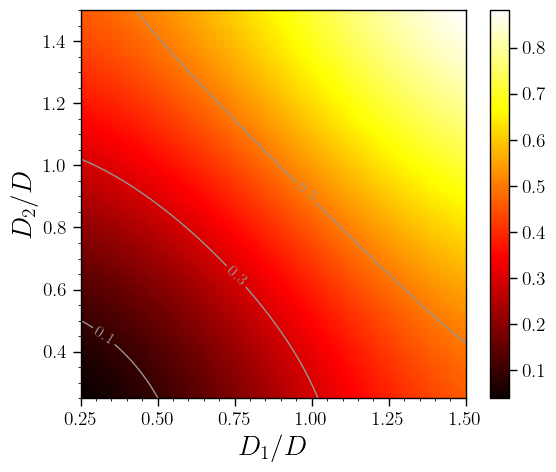

In [33]:
# ---------------------------------------------------
# Parameters
# ---------------------------------------------------
l0_symbol = sp.Symbol('l_0', real=True, positive=True)
L = 1/4 * l0
D = 1 * l0

D1_ = np.linspace(1/4, 3/2, 100) * l0
D2_ = np.linspace(1/4, 3/2, 100) * l0

D1, D2 = np.meshgrid(D1_, D2_)

Dx = 2 * l0
Dz = 150   # nm


# ---------------------------------------------------
# Plot
# ---------------------------------------------------

b_sk_values = compute_bk_values(D, L, 0, 0, Dz, 1)
b_sk_d1_values = compute_bk_values(D1, L, Dx, 0, Dz, 1)
b_sk_d2_values = compute_bk_values(D2, L, -Dx, 0, Dz, 1)

b_sk_values = [b_sk_values[key] + b_sk_d1_values[key] + b_sk_d2_values[key]  for key in b_sk_symbols]

Ex_vals = np.abs(Ex_f(1, B_tilde / omega_0, B_sk_tilde / omega_0, l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6))
Ey_vals = np.abs(Ey_f(1, B_tilde / omega_0, B_sk_tilde / omega_0, l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6))

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

theory_line = np.abs(B_cal_f(x0, l0, D, L, Dz)) * l0 * B_sk_tilde / 4 / (2 * np.pi * 1e6) * (1 - omega_c * B_tilde / omega_0**2)
Omega_Rabi = np.sqrt(Ex_vals**2 + Ey_vals**2)

deviation = np.abs((theory_line - Omega_Rabi)/theory_line)

im = ax.imshow(deviation, extent=[D1_.min()/D, D1_.max()/D, D2_.min()/D, D2_.max()/D],
               aspect='auto', origin='lower', cmap='hot')


# Add contour lines
contour_values = [0.1, 0.3, 0.5, 1, 1.5]  # whatever is relevant for B_val_vals
contours = ax.contour(D1_/D, D2_/D, deviation, levels=contour_values, colors="#969696", linewidths=1)
ax.clabel(contours, inline=True, fontsize=12, fmt="%.1f")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params()

# Title and labels
#ax.set_title(r"$\frac{\tilde{B}_{\mathrm{sk}}}{4M} \left( 1 - \frac{\omega_c \tilde{B}}{\omega_0^2} \right) |\mathcal{B}| l_0$")
ax.set_xlabel(r"$D_1/D$")
ax.set_ylabel(r"$D_2/D$")

# Ticks and grid
ax.tick_params(axis='both', which='major')
ax.minorticks_on()
ax.grid(False)

plt.tight_layout()
plt.show()

#fig.savefig("figures/rabi_frequency_strength_heatmap.pdf", dpi=300)

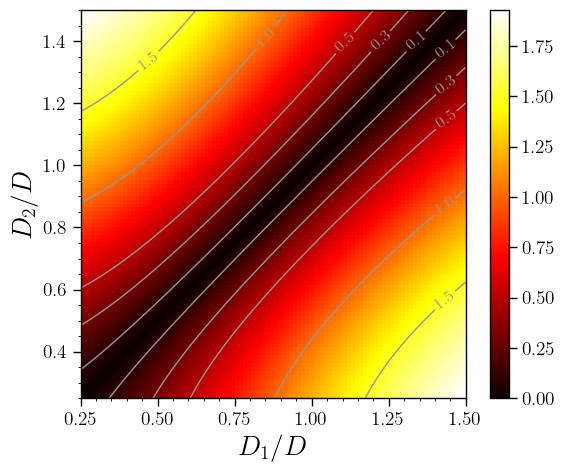

In [34]:
# ---------------------------------------------------
# Parameters
# ---------------------------------------------------
l0_symbol = sp.Symbol('l_0', real=True, positive=True)
L = 1/4 * l0
D = 1 * l0

D1_ = np.linspace(1/4, 3/2, 100) * l0
D2_ = np.linspace(1/4, 3/2, 100) * l0

D1, D2 = np.meshgrid(D1_, D2_)

Dx = 1.6 * l0
Dz = 150   # nm


# ---------------------------------------------------
# Plot
# ---------------------------------------------------

b_sk_values = compute_bk_values(D, L, 0, 0, Dz, 1)
b_sk_d1_values = compute_bk_values(D1, L, Dx, 0, Dz, 1)
b_sk_d2_values = compute_bk_values(D2, L, -Dx, 0, Dz, 1)

b_sk_values = [b_sk_values[key] + b_sk_d1_values[key] + b_sk_d2_values[key]  for key in b_sk_symbols]

Ex_vals = np.abs(Ex_f(1, B_tilde / omega_0, B_sk_tilde / omega_0, l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6))
Ey_vals = np.abs(Ey_f(1, B_tilde / omega_0, B_sk_tilde / omega_0, l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6))
Ez_vals = np.abs(Ez_f(1, B_tilde / omega_0, B_sk_tilde / omega_0, l0, x0, *b_sk_values) * omega_0 / (2*np.pi*1e6))

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

Omega_Rabi = np.sqrt(Ex_vals**2 + Ey_vals**2)

deviation = np.abs(Ez_vals/Omega_Rabi)

im = ax.imshow(deviation, extent=[D1_.min()/D, D1_.max()/D, D2_.min()/D, D2_.max()/D],
               aspect='auto', origin='lower', cmap='hot')


# Add contour lines
contour_values = [0.1, 0.3, 0.5, 1, 1.5]  # whatever is relevant for B_val_vals
contours = ax.contour(D1_/D, D2_/D, deviation, levels=contour_values, colors="#969696", linewidths=1)
ax.clabel(contours, inline=True, fontsize=12, fmt="%.1f")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params()

# Title and labels
#ax.set_title(r"$\frac{\tilde{B}_{\mathrm{sk}}}{4M} \left( 1 - \frac{\omega_c \tilde{B}}{\omega_0^2} \right) |\mathcal{B}| l_0$")
ax.set_xlabel(r"$D_1/D$")
ax.set_ylabel(r"$D_2/D$")

# Ticks and grid
ax.tick_params(axis='both', which='major')
ax.minorticks_on()
ax.grid(False)

plt.tight_layout()
plt.show()

#fig.savefig("figures/rabi_frequency_strength_heatmap.pdf", dpi=300)

# Skyrmion Simulations

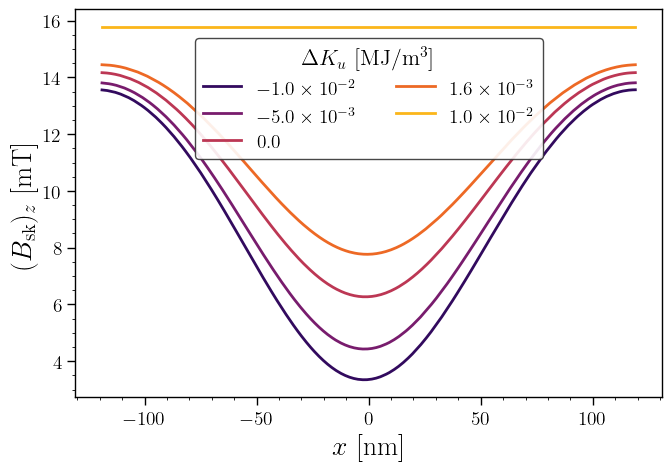

In [35]:

files = os.listdir(path)
line_files = [file for file in files if file.startswith("B_demag_+100nm") and file.endswith("_lineplot.csv")]
K_values = [float(re.search(r'K([-+]\d+\.\d+)', file).group(1)) for file in line_files]


fig, ax = plt.subplots(1, 1, figsize=(7, 5))

Ks_to_show = [-0.01, -0.005, 0.0, 0.0016, 0.01]

i_k_0 = np.argmin(np.abs(np.array(K_values) - 0.01))
line_file = line_files[i_k_0]
B_skyrmion_x, B_skyrmion_y, B_skyrmion_z, X, Y, Z, data = skyrmion_line_data(line_file)
B_z_base = B_skyrmion_z

colors = sns.color_palette("inferno", n_colors=len(Ks_to_show))

j = 0
for i in np.argsort(K_values):
    K = K_values[i]
    if K not in Ks_to_show:
        continue
    if np.isclose(K, 0.0):
        K = 0.0
    line_file = line_files[i]
    B_skyrmion_x, B_skyrmion_y, B_skyrmion_z, X, Y, Z, data = skyrmion_line_data(line_file)

    ax.plot(
        X,
        (B_skyrmion_z) * 1e3,
        label = f"K = {K}",
        color=colors[j], lw=2
    )
    j += 1

handles, _ = ax.get_legend_handles_labels()

def subs_scientific_notation(match):
    exp = int(match.group(1))
    return r"\times 10^{" + str(exp) + "}" if exp != 0 else ""

labels = [
    re.sub(r"e([+-]?\d+)", subs_scientific_notation, f"${K:.1e}$")
    for K in Ks_to_show
]

ax.legend(
    handles,
    labels,
    title=r"$\Delta K_u\ \mathrm{[MJ/m^3]}$",
    loc="upper center",
    ncol=2,             # spread out horizontally
    frameon=True,
    framealpha=0.9,
    edgecolor="0.2",
    borderaxespad=1.5,     # extra distance between legend and plot
)
 
y_min, y_max = ax.get_ylim()

ax.set_xlabel(r"$x$ [nm]")
ax.set_ylabel(r"$(B_{\mathrm{sk}})_z$ [mT]")
ax.tick_params(axis="both")

# ---------------------------------------------------
# Layout
# ---------------------------------------------------
ax.minorticks_on()
fig.tight_layout()

fig.savefig("figures/plotBdemagp100.pdf", dpi=300)

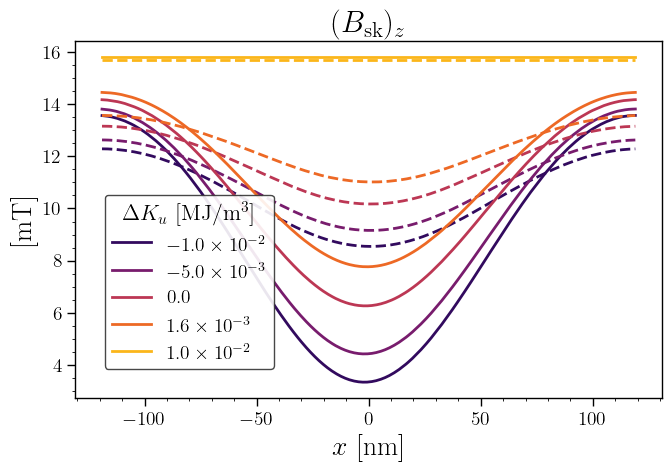

In [4]:

files = os.listdir(path)
line_files = [file for file in files if file.startswith("B_demag_-100nm") and file.endswith("_lineplot.csv")]
line_files_above = [file for file in files if file.startswith("B_demag_+100nm") and file.endswith("_lineplot.csv")]

K_values = [float(re.search(r'K([-+]\d+\.\d+)', file).group(1)) for file in line_files]
K_values_above = [float(re.search(r'K([-+]\d+\.\d+)', file).group(1)) for file in line_files_above]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

Ks_to_show = [-0.01, -0.005, 0.0, 0.0016, 0.01]

colors = sns.color_palette("inferno", n_colors=len(Ks_to_show))


for j, K in enumerate(Ks_to_show):
    i_bellow = np.argmin(np.abs(np.array(K_values) - K))
    i_above = np.argmin(np.abs(np.array(K_values_above) - K))

    if np.isclose(K, 0.0):
        K = 0.0
    line_file = line_files[i_bellow]
    B_skyrmion_x, B_skyrmion_y, B_skyrmion_z, X, Y, Z, data = skyrmion_line_data(line_file)
    B_skyrmion_x_above, B_skyrmion_y_above, B_skyrmion_z_above, X_above, Y_above, Z_above, data_above = skyrmion_line_data(line_files_above[i_above])

    ax.plot(
        X,
        (B_skyrmion_z) * 1e3,
        color=colors[j], lw=2,
        ls='--'
    )

    ax.plot(
        X,
        (B_skyrmion_z_above) * 1e3,
        color=colors[j], lw=2,
    )

    j += 1


def subs_scientific_notation(match):
    exp = int(match.group(1))
    return r"\times 10^{" + str(exp) + "}" if exp != 0 else ""

labels = [
    re.sub(r"e([+-]?\d+)", subs_scientific_notation, f"${K:.1e}$")
    for K in Ks_to_show
]


color_handles = [
    Line2D([0], [0], color=colors[i], lw=2,
           label=labels[i])
    for i in range(len(Ks_to_show))
]

ax.legend(
    handles= color_handles,
    title=r"$\Delta K_u\ \mathrm{[MJ/m^3]}$",
    loc="lower left",
    ncol=1,             # spread out horizontally
    frameon=True,
    framealpha=0.9,
    edgecolor="0.2",
    borderaxespad=1.5,     # extra distance between legend and plot
)

ax.set_xlabel(r"$x$ [nm]", fontsize=20)
ax.set_ylabel(r"$\left[\mathrm{mT}\right]$")
ax.set_title(r"$(B_{\mathrm{sk}})_z$")
ax.tick_params(axis="both")

# ---------------------------------------------------
# Layout
# ---------------------------------------------------
ax.minorticks_on()
fig.tight_layout()

fig.savefig("figures/plotBdemag.pdf", dpi=300)

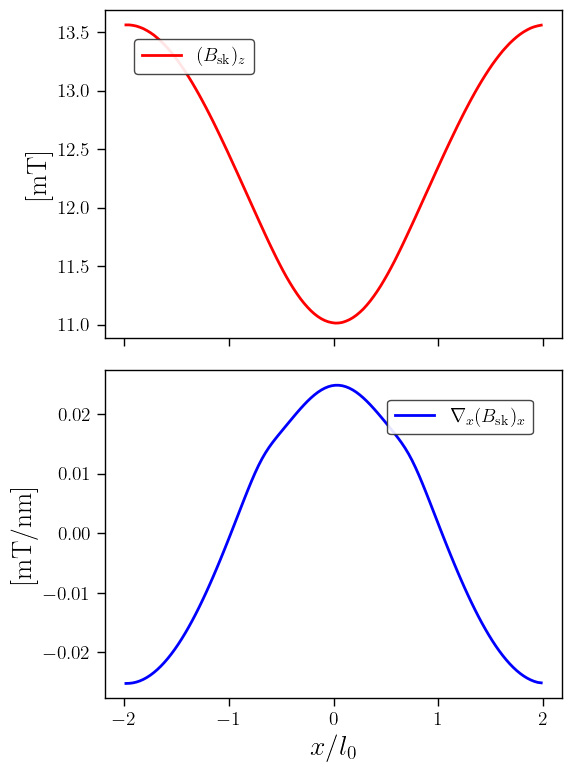

In [6]:

files = os.listdir(path)
line_files = [file for file in files if file.startswith("B_demag_-100nm") and not file.endswith("_lineplot.csv")]

K_values = [float(re.search(r'K([-+]\d+\.\d+)', file).group(1)) for file in line_files]


Ks_to_show = [0.0016]

colors = sns.color_palette("inferno", n_colors=len(Ks_to_show))


line_file = line_files[np.argmin(np.abs(np.array(K_values) - Ks_to_show[0]))]
B_skyrmion_x, B_skyrmion_y, B_skyrmion_z, X, Y, Z, data = skyrmion_data(line_file)

x_shape = X.shape[0]
X = X[x_shape//2, :]

B_skyrmion_x = B_skyrmion_x[x_shape//2, :]
B_skyrmion_y = B_skyrmion_y[x_shape//2, :]
B_skyrmion_z = B_skyrmion_z[x_shape//2, :]

grad_B_skyrmion_x = np.gradient(B_skyrmion_x, np.abs(X[1] - X[0]))

fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
ax = axs[0]

# --- Left y-axis (primary): B field ---
ax.plot(
    X / 60,
    B_skyrmion_z * 1e3,       # mT
    color='red',
    lw=2,
    ls='-',
    label=r"$(B_\mathrm{sk})_z$ "
)


ax.set_ylabel(r"[mT]", fontsize=20)

# --- Right y-axis (secondary): Gradient ---
#ax2 = ax.twinx()  # <---- THIS CREATES THE SECOND AXIS
ax2 = axs[1]
ax2.set_xlabel(r"$x/l_0$", fontsize=20)

ax2.plot(
    X / 60,
    grad_B_skyrmion_x * 1e3,   # mT/nm
    color='blue',
    lw=2,
    ls='-',
    label=r"$\nabla_x (B_\mathrm{sk})_x$ "
)

ax2.set_ylabel(r"[mT/nm]", fontsize=20)

ax.legend(
    loc="upper left",
    ncol=1,             # spread out horizontally
    frameon=True,
    framealpha=0.9,
    edgecolor="0.2",
    borderaxespad=1.5,     # extra distance between legend and plot
)

ax2.legend(
    loc="upper right",
    ncol=1,             # spread out horizontally
    frameon=True,
    framealpha=0.9,
    edgecolor="0.2",
    borderaxespad=1.5,     # extra distance between legend and plot
)

fig.tight_layout()
fig.savefig("figures/plotBdemag_gradient.pdf", dpi=300)

In [4]:
from Cylindrical_Magnet import CylindricalMagnet

l0_val = 60

Skyrmion = CylindricalMagnet(
    R=83/2/l0_val,
    L=100/l0_val,
    position=np.array([0, 0, 150/l0_val]))

Skyrmion.B0=-1

z_vals = np.linspace(-10/l0_val, 170/l0_val, 20)
x_vals = np.linspace(-60/l0_val, 60/l0_val, 20)
X_vals, Z_vals = np.meshgrid(x_vals, z_vals)

Bx_s, By_s, Bz_s = np.zeros_like(Z_vals), np.zeros_like(Z_vals), np.zeros_like(Z_vals)

M = 1e6  # A/m
B0_val = -mu_0 * M / (4 * np.pi)  # in T

for i in tqdm(range(Z_vals.shape[0])):
    for j in range(Z_vals.shape[1]):
        B_vec = Skyrmion.B({'B0':B0_val, 'R':83/2/l0_val, 'L':15/l0_val, 'position': np.array([0, 0, 150/l0_val])}, np.array([X_vals[i, j], 0, Z_vals[i, j]]))
        Bx_s[i, j], By_s[i, j], Bz_s[i, j] = B_vec
        Bz_s[i, j] += 16e-3  # add external field

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 41.14it/s]


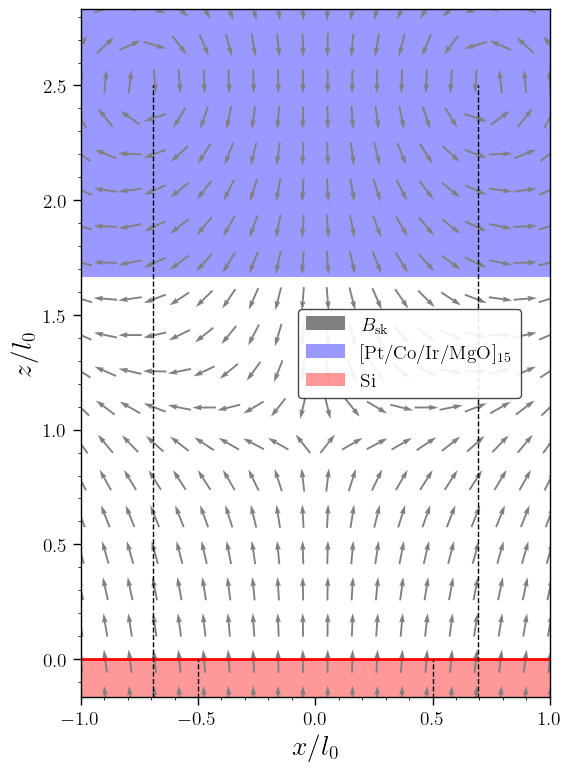

In [501]:

l0_val = 60

# --- Plot ---
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

norm = np.sqrt(Bx_s**2 + Bz_s**2)
Bx_s /= norm
Bz_s /= norm

#norm /= norm.max()
colors = sns.color_palette("inferno", as_cmap=True)

ax.quiver(X_vals, Z_vals, Bx_s, Bz_s, pivot='mid', scale=20, width=0.004, headwidth=3, minlength=0.1, color='gray', label=r'$B_\mathrm{sk}$')

ax.set_ylim(-10/l0_val, 170/l0_val)
ax.set_xlim(-60/l0_val, 60/l0_val)
ax.set_xlabel(r"$x/l_0$", fontsize=20)
ax.set_ylabel(r"$z/l_0$", fontsize=20)
ax.hlines(0, -100/l0_val, 100/l0_val, color='red', lw=2, ls='-')
#ax.hlines(150/l0_val, -100/l0_val, 100/l0_val, color='black', lw=1, ls='--')

ax.vlines(-30/l0_val, -40/l0_val, 0, color='black', lw=1, ls='--')
ax.vlines(30/l0_val, -40/l0_val, 0, color='black', lw=1, ls='--')
ax.vlines(-83/2/l0_val, -100/l0_val, 150/l0_val, color='black', lw=1, ls='--')
ax.vlines(83/2/l0_val, -100/l0_val, 150/l0_val, color='black', lw=1, ls='--')

#ax.scatter([-30/l0_val, 30/l0_val], [0, 0], color='red', s=10, label='Qubit positions', zorder=5)
#ax.scatter([-83/2/l0_val, 83/2/l0_val], [150/l0_val, 150/l0_val], color='blue', s=10, label='Skyrmion positions', zorder=5)

# Rectangle for magnet
x_min, x_max = ax.get_xlim()
rect = plt.Rectangle((x_min, 100/l0_val), x_max - x_min, 100/l0_val, linewidth=1, edgecolor='none', facecolor='blue', ls='--', alpha=0.4, zorder=0, label=r'$[\mathrm{Pt/Co/Ir/MgO}]_{15}$')
ax.add_patch(rect)
rect = plt.Rectangle((x_min, -20/l0_val), x_max - x_min, 20/l0_val, linewidth=1, edgecolor='none', facecolor='red', ls='--', alpha=0.4, zorder=0, label=r'$\mathrm{Si}$')
ax.add_patch(rect)

ax.legend(
    ncol=1,             # spread out horizontally
    frameon=True,
    framealpha=0.9,
    edgecolor="0.2",
    borderaxespad=1.5,     # extra distance between legend and plot
)

ax.set_xticks([-1, -0.5, 0, 0.5, 1])

ax.minorticks_on()
fig.tight_layout()
fig.savefig("figures/skyrmion_qubit_scheme.pdf", dpi=300)

[-49.742  51.41 ] [101.152]


K = -0.01, M_z = 13.913202495407017 mT, D_tile = 240
[-47.362  49.27 ] [96.632]
K = -0.005, M_z = 14.126230121518091 mT, D_tile = 240
[-43.554  45.7  ] [89.254]
K = 0.0, M_z = 14.50192470503001 mT, D_tile = 240
[-39.984  43.08 ] [83.064]
K = 0.0016, M_z = 14.830801442200999 mT, D_tile = 240
[] []
0.015671999999999995


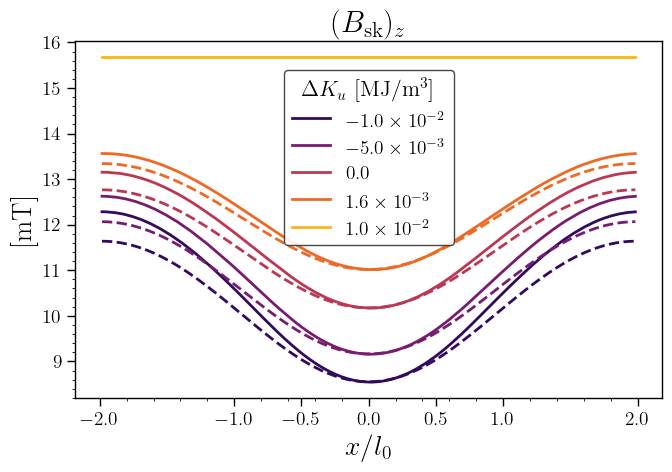

In [ ]:

files = os.listdir(path)
line_files = [file for file in files if file.startswith("B_demag_-100nm") and file.endswith("_lineplot.csv")]
mag_files = [file for file in files if file.startswith("magnetization") and file.endswith("_lineplot.csv")]

K_mag_values = [float(re.search(r'K([-+]\d+\.\d+)', file).group(1)) for file in mag_files]
K_values = [float(re.search(r'K([-+]\d+\.\d+)', file).group(1)) for file in line_files]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

Ks_to_show = [-0.01, -0.005, 0.0, 0.0016, 0.01]

colors = sns.color_palette("inferno", n_colors=len(Ks_to_show))


for j, K in enumerate(Ks_to_show):
    i_bellow = np.argmin(np.abs(np.array(K_values) - K))
    i_mag = np.argmin(np.abs(np.array(K_mag_values) - K))
    if np.isclose(K, 0.0):
        K = 0.0
    line_file = line_files[i_bellow]
    mag_file = mag_files[i_mag]
    
    M_skyrmion_x, M_skyrmion_y, M_skyrmion_z, X, Y, Z, data = skyrmion_line_data(mag_file)

    # where M_skyrmion_z changes sign, set to 0
    sign_changes = np.where(np.diff(np.sign(M_skyrmion_z)))[0]
    Diameter = np.diff(X[sign_changes])
    print(X[sign_changes], np.diff(X[sign_changes]))

    B_skyrmion_x, B_skyrmion_y, B_skyrmion_z, X, Y, Z, data = skyrmion_line_data(line_file)
    

    ax.plot(
        X/60,
        (B_skyrmion_z) * 1e3,
        color=colors[j], lw=2,
        ls='-'
    )

    if Diameter.size == 0:
        print(B_skyrmion_z.mean())
        j+=1
        continue

 
    # 2x2 tiling
    D_tile = 240
    B_vec = np.array([Skyrmion.B({'B0':-0.1, 'R':Diameter/2, 'L':15, 'position': np.array([0, 0, 150])}, np.array([x_pos, 0, 0])) for x_pos in X])
    for dx_tile in [-1, 0, 1]:
        for dy_tile in [-1, 0, 1]:
            if dx_tile == 0 and dy_tile == 0:
                continue
            B_vec += np.array([Skyrmion.B({'B0':-0.1, 'R':Diameter/2, 'L':15, 'position': np.array([dx_tile * D_tile, dy_tile * D_tile, 150])}, np.array([x_pos, 0, 0])) for x_pos in X])

    M_z = (B_skyrmion_z[X.shape[0]//2 - 50: X.shape[0]//2  + 50] - B_vec[X.shape[0]//2 - 50: X.shape[0]//2  + 50, 2]).mean()
    print(f"K = {K}, M_z = {M_z*1e3} mT, D_tile = {D_tile}")

    ax.plot(
        X/60,
        (B_vec[:, 2]) * 1e3 + M_z*1e3,
        color=colors[j], lw=2,
        ls='--'
    )


    j += 1


def subs_scientific_notation(match):
    exp = int(match.group(1))
    return r"\times 10^{" + str(exp) + "}" if exp != 0 else ""

labels = [
    re.sub(r"e([+-]?\d+)", subs_scientific_notation, f"${K:.1e}$")
    for K in Ks_to_show
]


color_handles = [
    Line2D([0], [0], color=colors[i], lw=2,
           label=labels[i])
    for i in range(len(Ks_to_show))
]

ax.legend(
    handles= color_handles,
    title=r"$\Delta K_u\ \mathrm{[MJ/m^3]}$",
    ncol=1,             # spread out horizontally
    frameon=True,
    framealpha=0.9,
    edgecolor="0.2",
    borderaxespad=1.5,     # extra distance between legend and plot
)

ax.set_xlabel(r"$x/l_0$", fontsize=20)
ax.set_xticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])

ax.set_ylabel(r"$\left[\mathrm{mT}\right]$")
ax.set_title(r"$(B_{\mathrm{sk}})_z$")
ax.tick_params(axis="both")

# ---------------------------------------------------
# Layout
# ---------------------------------------------------
ax.minorticks_on()
fig.tight_layout()

fig.savefig("figures/plotBdemag.pdf", dpi=300)

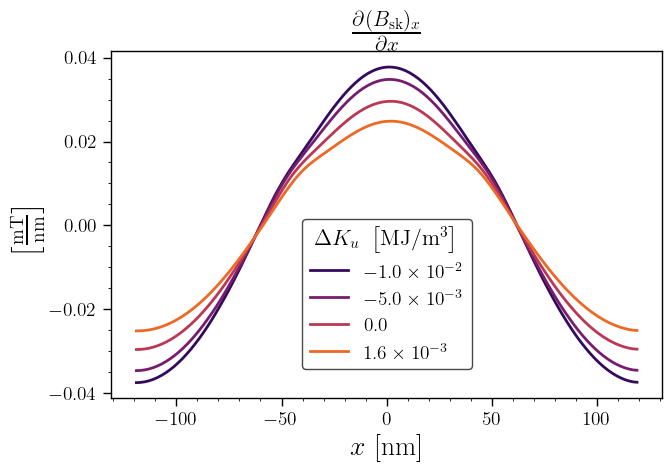

In [ ]:

files = os.listdir(path)
line_files = [file for file in files if file.startswith("B_demag_-100nm") and not file.endswith("_lineplot.csv")]

K_values = [float(re.search(r'K([-+]\d+\.\d+)', file).group(1)) for file in line_files]



fig, ax = plt.subplots(1, 1, figsize=(7, 5))

Ks_to_show = [-0.01, -0.005, 0.0, 0.0016]

colors = sns.color_palette("inferno", n_colors=len(Ks_to_show) + 1)

j = 0
for i in np.argsort(K_values):
    K = K_values[i]
    if K not in Ks_to_show:
        continue
    if np.isclose(K, 0.0):
        K = 0.0
    line_file = line_files[i]
    B_skyrmion_x, B_skyrmion_y, B_skyrmion_z, X, Y, Z, data = skyrmion_data(line_file)

    x_shape = X.shape[0]
    X = X[x_shape//2, :]
    B_skyrmion_x = B_skyrmion_x[x_shape//2, :]

    grad_B_skyrmion_x = np.gradient(B_skyrmion_x, np.abs(X[1]-X[0]))

    ax.plot(
        X,
        (grad_B_skyrmion_x) * 1e3,
        label = f"K = {K}",
        color=colors[j], lw=2
    )
    j += 1

handles, _ = ax.get_legend_handles_labels()

def subs_scientific_notation(match):
    exp = int(match.group(1))
    return r"\times 10^{" + str(exp) + "}" if exp != 0 else ""

labels = [
    re.sub(r"e([+-]?\d+)", subs_scientific_notation, f"${K:.1e}$")
    for K in Ks_to_show
]

ax.legend(
    handles,
    labels,
    title=r"$\Delta K_u\ \left[\mathrm{MJ/m^3}\right]$",
    loc="lower center",
    ncol=1,             # spread out horizontally
    frameon=True,
    framealpha=0.9,
    edgecolor="0.2",
    borderaxespad=1.5,     # extra distance between legend and plot
)

ax.set_xlabel(r"$x$ [nm]")
ax.set_title(r"$\frac{\partial (B_{\mathrm{sk}})_x}{\partial x}$")
ax.set_ylabel(r"$\left[\frac{\mathrm{mT}}{\mathrm{nm}}\right]$")
ax.tick_params(axis="both")

# yaxis scientific
#ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# ---------------------------------------------------
# Layout
# ---------------------------------------------------
ax.minorticks_on()
fig.tight_layout()

fig.savefig("figures/plotdBdx.pdf", dpi=300)

[-49.742  51.41 ] [101.152]
[-47.362  49.27 ] [96.632]
[-43.554  45.7  ] [89.254]
[-39.984  43.08 ] [83.064]
[] []


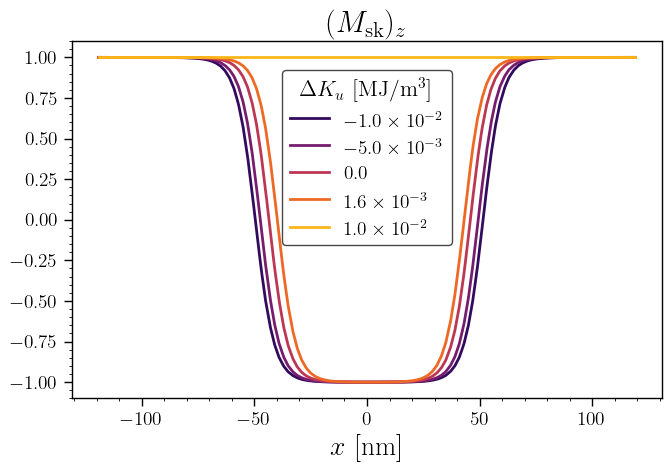

In [40]:

files = os.listdir(path)
line_files = [file for file in files if file.startswith("magnetization") and file.endswith("_lineplot.csv")]
K_values = [float(re.search(r'K([-+]\d+\.\d+)', file).group(1)) for file in line_files]


fig, ax = plt.subplots(1, 1, figsize=(7, 5))

Ks_to_show = [-0.01, -0.005, 0.0, 0.0016, 0.01]

colors = sns.color_palette("inferno", n_colors=len(Ks_to_show))

j = 0
for i in np.argsort(K_values):
    K = K_values[i]
    if K not in Ks_to_show:
        continue
    if np.isclose(K, 0.0):
        K = 0.0
    line_file = line_files[i]
    M_skyrmion_x, M_skyrmion_y, M_skyrmion_z, X, Y, Z, data = skyrmion_line_data(line_file)


    # where M_skyrmion_z changes sign, set to 0
    sign_changes = np.where(np.diff(np.sign(M_skyrmion_z)))[0]
    print(X[sign_changes], np.diff(X[sign_changes]))

    ax.plot(
        X,
        (M_skyrmion_z),
        label = f"K = {K}",
        color=colors[j], lw=2
    )
    j += 1

handles, _ = ax.get_legend_handles_labels()

def subs_scientific_notation(match):
    exp = int(match.group(1))
    return r"\times 10^{" + str(exp) + "}" if exp != 0 else ""

labels = [
    re.sub(r"e([+-]?\d+)", subs_scientific_notation, f"${K:.1e}$")
    for K in Ks_to_show
]

ax.legend(
    handles,
    labels,
    title=r"$\Delta K_u\ \mathrm{[MJ/m^3]}$",
    loc="upper center",
    ncol=1,             # spread out horizontally
    frameon=True,
    framealpha=0.9,
    edgecolor="0.2",
    borderaxespad=1.5,     # extra distance between legend and plot
)

ax.set_xlabel(r"$x$ [nm]")
ax.set_title(r"$(M_{\mathrm{sk}})_z$")
ax.tick_params(axis="both")

# ---------------------------------------------------
# Layout
# ---------------------------------------------------
ax.minorticks_on()
fig.tight_layout()

fig.savefig("figures/plotMz.pdf", dpi=300)